In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [2]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.gen(x)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 3e-4
z_dim = 64
image_dim = 784
batch_size = 32
num_epochs = 50

In [5]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)

In [6]:
fixed_noise = torch.randn(batch_size, z_dim).to(device)
transforms = torchvision.transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5,], [0.5,])])

In [7]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)

In [8]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)

In [10]:
criterion = nn.BCELoss()

In [11]:
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step=0

In [12]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(real.shape[0], -1).to(device)
        batch_size = real.shape[0]

        #Train Discriminator
        opt_disc.zero_grad()
        
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real)
        loss_D_real = criterion(disc_real, torch.ones(disc_real.shape[0], 1).to(device))
        disc_fake = disc(fake)
        loss_D_fake = criterion(disc_fake, torch.zeros(disc_real.shape[0], 1).to(device))
        loss_D_total = (loss_D_real + loss_D_fake) / 2
        loss_D_total.backward(retain_graph=True)
        opt_disc.step()


        #Train Generator
        opt_gen.zero_grad()
        
        output = disc(fake)
        loss_G = criterion(output, torch.ones(output.shape[0], 1).to(device))
        loss_G.backward()
        opt_gen.step()

        #Tensorboard stuff
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] \ "
                f"Loss D: {loss_D_total:.4f}, Loss G: {loss_G:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise).view(-1, 1, 28, 28)
                data = real.view(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Generated Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/50] \ Loss D: 0.6594, Loss G: 0.6849
Epoch [1/50] \ Loss D: 0.3873, Loss G: 1.3702
Epoch [2/50] \ Loss D: 0.3988, Loss G: 1.4343
Epoch [3/50] \ Loss D: 0.5193, Loss G: 1.2034
Epoch [4/50] \ Loss D: 0.7504, Loss G: 0.8864
Epoch [5/50] \ Loss D: 0.5536, Loss G: 1.1914
Epoch [6/50] \ Loss D: 0.8659, Loss G: 0.6394
Epoch [7/50] \ Loss D: 0.4684, Loss G: 1.4066
Epoch [8/50] \ Loss D: 0.5996, Loss G: 1.1461
Epoch [9/50] \ Loss D: 0.6581, Loss G: 1.1523
Epoch [10/50] \ Loss D: 0.5981, Loss G: 1.1019


KeyboardInterrupt: 

In [13]:
import tensorboard

In [14]:
%load_ext tensorboard

In [27]:
%tensorboard --logdir=runs  --host localhost

In [20]:
torch.save(gen, "MNIST_generator.pt")

In [21]:
torch.save(disc, "MNIST_discriminator.pt")

torch.Size([784])

In [29]:
import matplotlib.pyplot as plt

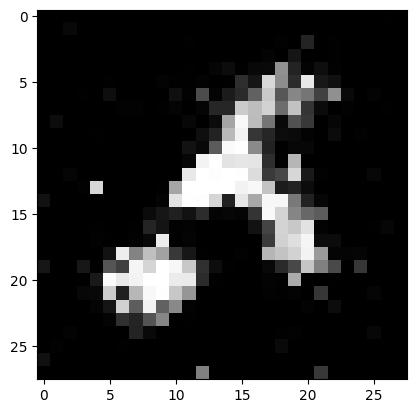

In [55]:
val_noise = torch.randn(z_dim).to(device)
gen_output = gen(val_noise)
gen_output = gen_output.view(28, 28).to('cpu')
plt.imshow(gen_output.detach().numpy(), cmap='gray')